# Test 2 — Regression: Modeling and 100-Step Forecast (No Future Regressors)

**Dataset:** Vito, S. (2008). *Air Quality* [Dataset]. UCI Machine Learning Repository. https://doi.org/10.24432/C59K5F  
**Target:** `y_nonseasonal = diff(CO_daily)` built and validated in `01_EDA.ipynb` (non-seasonal; stationarity checked).

**Goal of this notebook**
1. Load the **processed** data (`CO_daily`, `y_nonseasonal`).  
2. Define a **model zoo** that respects the constraint: *no future exogenous values available*.  
3. **Backtest** via expanding windows and compare models with **MAE**, **RMSE**, and **MASE**.
4. Fit the **winner** on the full history and produce a **100-step** forecast.  

## IMPORTS AND DATA LOADING

In [1]:
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
import warnings
warnings.filterwarnings('ignore')
from statsmodels.tools.sm_exceptions import ValueWarning
warnings.filterwarnings("ignore", message="No frequency information", category=ValueWarning)


# reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
random.seed(RANDOM_STATE)


# package versions
import sklearn
print('python', sys.version.split()[0])
print('pandas', pd.__version__)
print('numpy', np.__version__)
print('scikit-learn', sklearn.__version__)
print('matplotlib', plt.matplotlib.__version__)
print('seaborn', sns.__version__)


# plot defaults
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5)

python 3.10.18
pandas 2.3.2
numpy 2.2.6
scikit-learn 1.7.2
matplotlib 3.10.6
seaborn 0.13.2


In [2]:
DATA_PATH = Path('../data/processed/air_quality_daily.parquet')
df = pd.read_parquet(DATA_PATH)
df = df.sort_index()

y = df['y_nonseasonal'].copy()     # target: Δ CO_daily
y_level = df['CO_daily'].copy()    # level to invert diffs for plots

y.tail(), y_level.tail()

(2005-03-31   -0.529167
 2005-04-01   -0.278804
 2005-04-02   -0.254529
 2005-04-03    0.287500
 2005-04-04    0.936905
 Name: y_nonseasonal, dtype: float64,
 2005-03-31    1.387500
 2005-04-01    1.108696
 2005-04-02    0.854167
 2005-04-03    1.141667
 2005-04-04    2.078571
 Name: CO_daily, dtype: float64)

## METRICS

We use **MAE**, **RMSE**, and **MASE** (scaled by naive forecast) for robust comparison on non-seasonal series.

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


def mase(y_true: np.ndarray, y_pred: np.ndarray, y_insample: np.ndarray) -> float:
    # Naive-1 errors on insample
    naive_err = np.abs(y_insample[1:] - y_insample[:-1]).mean()
    return np.mean(np.abs(y_true - y_pred)) / (naive_err + 1e-12)


## REGRESSION MODELS WITH NO REGRESSORS

A time series regression model with no external regressors relies on the internal dynamics of the series itself, using components like **autoregressive (AR)** terms, which predict future values based on past observations, and **moving average (MA)** terms, which account for the impact of past errors. This type of model is used when a time series has no external factors influencing it, and its behavior is primarily driven by its own past values and the past behavior of its forecast errors.  

- **Autoregressive (AR) component:** It models the relationship between an observation and a number of its own lagged (past) values. For example, a value at time `t` might depend on values at `t-1` and `t-2`. 
- **Moving Average (MA) component:** It models the influence of past forecast errors on the current value of the series. It captures the impact of unexpected shocks or noises from previous periods. 
- **Stochastic Process:** A time series represents a single outcome or realization of an underlying stochastic (random) process. A model with no external regressors attempts to capture the dynamics of this process using only its own past information. 


#### BASELINE MODELS 

Before fitting any regression model, we need to define **baselines** to anchor performance and avoid over-claiming gains They provide a **lower bound**, any candidate model must beat them (e.g., on **MASE**, **MAE**, **RMSE**). Therefore, they expose **data difficulty**, so if baselines are already strong, gains will be modest, and they help interpret **MASE**; by construction MASE compares against the naive‑1 forecast error. We define the following ones:

- **Naive**: it assumes the next value will be the same as the last observed valud:  $ \hat{y}_{t+1} = y_t  $
- **Drift**: it is an extension of the naive method, which extrapolates the linear slope from the start to the last point:  $  \hat{y}_{t+h} = y_t + h \cdot \frac{y_t - y_0}{t-1}  $ 

In [4]:
from dataclasses import dataclass

@dataclass
class NaiveLast:
    def fit(self, y_train: pd.Series):
        self.last = y_train.iloc[-1]
        return self
    def predict(self, steps: int) -> np.ndarray:
        return np.full(steps, self.last)
    def predict_one_step(self, last_value: float) -> float:
        return last_value

@dataclass
class Drift:
    def fit(self, y_train: pd.Series):
        self.y0 = y_train.iloc[0]
        self.yT = y_train.iloc[-1]
        self.n = len(y_train)
        return self
    def predict(self, steps: int) -> np.ndarray:
        slope = (self.yT - self.y0) / max(self.n-1, 1)
        return np.array([self.yT + (h+1)*slope for h in range(steps)])

#### ARIMA
**AutoRegressive Integrated Moving Average (ARIMA)** is a classic statistical model for time series forecasting. **ARIMA(p,d,q)** model where `p` and `q` define the order of the **AR** and **MA** components, respectively, and `d` represents the degree of differencing needed to achieve stationarity. An **AR(1)** model, a very simple form, could be written as:
$$ Y(t) = β₀ + β₁Y(t-1) + ε(t)$$
Where `Y(t)` is the value at time t, `Y(t-1)` is the value at the previous time period, `β₀` is the intercept, `β₁` is the coefficient for the lagged value, and `ε(t)` is the error term. This model uses only the past value of the series Y to predict the current value. 

We perform a small grid over (p,d,q) in {0..2} to select the model by AIC and fit **SARIMAX** with no seasonal terms and no exog.

In [5]:
from statsmodels.tsa.api import SARIMAX

In [6]:
def fit_best_arima(y_train: pd.Series, max_p: int = 2, max_d: int = 2, max_q: int = 2):
    best_res = None
    best_aic = np.inf
    best_order = None
    for p in range(max_p+1):
        for d in range(max_d+1):
            for q in range(max_q+1):
                try:
                    # We fit a SARIMAX with no seasonal terms and no exog
                    model = SARIMAX(y_train, order=(p,d,q), seasonal_order=(0,0,0,0), trend='n', enforce_stationarity=False, enforce_invertibility=False)
                    res = model.fit(disp=False)
                    # AIC = Akaike Information Criterion, a measure of model quality
                    if res.aic < best_aic:
                        best_aic = res.aic
                        best_res = res
                        best_order = (p,d,q)
                except Exception:
                    continue
    return best_res, best_order, best_aic

#### ETS (Exponential Smoothing)

ETS stands for Error–Trend–Seasonality. It is a state-space forecasting family where you choose:
- **Error (E):** Represents the random fluctuations in the data and allows for the generation of forecast distributions and prediction intervals. It can be **additive (A)** or **multiplicative (M).***
- **Trend (T):** Captures the overall upward or downward movement in the series over time. It can be **none (N)**, **additive (A)** or **multiplicative (M)**.
- **Seasonality (S):** Accounts for repeating patterns or cycles within a fixed period, such as daily, weekly, or yearly. It can be **none (N)**, **additive (A)** or **multiplicative (M)**.

Since our target is the first difference of daily CO (non-seasonal), using no seasonal component is correct.

In [7]:
from statsmodels.tsa.api import ExponentialSmoothing

In [8]:
def fit_best_ets(y_train: pd.Series):
    # Try with additive trend; fallback to simple
    try:
        model = ExponentialSmoothing(y_train, trend='add', seasonal=None, initialization_method='heuristic')
        res = model.fit(optimized=True)
        return res, 'ETS(additive trend)'
    except Exception:
        model = ExponentialSmoothing(y_train, trend=None, seasonal=None, initialization_method='heuristic')
        res = model.fit(optimized=True)
        return res, 'SES'


#### ML univariate with lag features

The main goaal of this model is to treat forecasting as a regression problem where the predictors are **past values of the target**.  For a non-seasonal target `y_t` (here, the daily first difference of CO), we build a tabular dataset with:

- **Lag features:** `y_{t-1}, y_{t-2}, …, y_{t-30}`
- **Rolling stats (from past only):** 
  - means: `mean(y_{t-7..t-1})`, `mean(y_{t-14..t-1})`
  - stds: `std(y_{t-7..t-1})`, `std(y_{t-14..t-1})`

**Model choice.**  
`HistGradientBoostingRegressor` (HGBR) — a tree-based gradient boosting that is:
- **Fast** and memory-efficient (histogram-based).
- Handles **nonlinearities** and **interactions** without manual feature engineering.
- Robust to monotone transformations; **no scaling** required.

**Training.**  
Fit the model on the supervised table `(X, y)` built from history. Then evaluate with **expanding-window backtesting** and use **MASE** (primary), MAE, RMSE.

**Forecasting strategy (recursive rollout).**  
To forecast `H=100` steps:
1. Predict `ŷ_{t+1}` using the last observed lags.  
2. **Append** `ŷ_{t+1}` to the history and recompute the lags → predict `ŷ_{t+2}`.  
3. Repeat until 100 steps are produced.  
This mirrors real-time usage when future true values are unknown.

In [9]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [10]:
def build_lag_features(y_series: pd.Series, max_lag: int = 30) -> pd.DataFrame:
    dfX = pd.DataFrame({'y': y_series})
    for lag in range(1, max_lag+1):
        dfX[f'lag_{lag}'] = y_series.shift(lag)
    # rolling stats
    dfX['roll_mean_7'] = y_series.shift(1).rolling(7).mean()
    dfX['roll_std_7']  = y_series.shift(1).rolling(7).std()
    dfX['roll_mean_14'] = y_series.shift(1).rolling(14).mean()
    dfX['roll_std_14']  = y_series.shift(1).rolling(14).std()
    dfX = dfX.dropna()
    y_out = dfX.pop('y')
    return dfX, y_out

def recursive_forecast_sklearn(model, y_series: pd.Series, steps: int, max_lag: int = 30) -> np.ndarray:
    hist = y_series.copy()
    preds = []
    for _ in range(steps):
        feats = {}
        for lag in range(1, max_lag+1):
            feats[f'lag_{lag}'] = hist.iloc[-lag]
        feats['roll_mean_7'] = hist.iloc[-8:-1].mean() if len(hist) >= 8 else hist.mean()
        feats['roll_std_7']  = hist.iloc[-8:-1].std() if len(hist) >= 8 else hist.std()
        feats['roll_mean_14'] = hist.iloc[-15:-1].mean() if len(hist) >= 15 else hist.mean()
        feats['roll_std_14']  = hist.iloc[-15:-1].std() if len(hist) >= 15 else hist.std()
        X = pd.DataFrame([feats])
        yhat = model.predict(X)[0]
        preds.append(yhat)
        # We append prediction as if observed
        next_idx = hist.index[-1] + pd.offsets.Day(1)
        hist.loc[next_idx] = yhat
    return np.array(preds)



## MODELS EVALUATION

We evaluate each model across **expanding windows** using `TimeSeriesSplit`.  
- **Horizon per fold:** 14 days (set `H` below).  
- Models: **Naive**, **Drift**, **ARIMA**, **ETS**, **HGBR(lags)**.  
- Metrics per fold: **MASE**, **MAE**, **RMSE**.

In [11]:
from sklearn.model_selection import TimeSeriesSplit

In [12]:

def evaluate_backtest(y_series: pd.Series, horizon: int = 14, n_splits: int = 6):
    y_series = y_series.sort_index()
    freq = pd.infer_freq(y_series.index) or 'D'
    y_series = y_series.asfreq(freq)

    tscv = TimeSeriesSplit(n_splits=n_splits)
    records = []

    for fold, (tr_idx, te_idx) in enumerate(tscv.split(y_series), start=1):
        y_tr, y_te = y_series.iloc[tr_idx].asfreq(freq), y_series.iloc[te_idx].asfreq(freq)
        # Limit horizon to test length
        H = min(horizon, len(y_te))

        # Baselines models
        naive = NaiveLast().fit(y_tr)
        drift = Drift().fit(y_tr)
        yhat_naive = naive.predict(H)
        yhat_drift = drift.predict(H)

        mae_naive = mean_absolute_error(y_te[:H], yhat_naive)
        rmse_naive = mean_squared_error(y_te[:H], yhat_naive)
        mase_naive = mase(y_te[:H].values, yhat_naive, y_tr.values)

        mae_drift = mean_absolute_error(y_te[:H], yhat_drift)
        rmse_drift = mean_squared_error(y_te[:H], yhat_drift)
        mase_drift = mase(y_te[:H].values, yhat_drift, y_tr.values)

        records += [
            {'fold': fold, 'model': 'NaiveLast', 'MAE': mae_naive, 'RMSE': rmse_naive, 'MASE': mase_naive},
            {'fold': fold, 'model': 'Drift', 'MAE': mae_drift, 'RMSE': rmse_drift, 'MASE': mase_drift},
        ]

        # ARIMA grid
        arima_res, order, aic = fit_best_arima(y_tr)
        yhat_arima = arima_res.get_forecast(steps=H).predicted_mean.values
        records.append({'fold': fold, 'model': f'ARIMA{order}', 'MAE': mean_absolute_error(y_te[:H], yhat_arima),
                        'RMSE': mean_squared_error(y_te[:H], yhat_arima),
                        'MASE': mase(y_te[:H].values, yhat_arima, y_tr.values)})

        # ETS
        ets_res, ets_name = fit_best_ets(y_tr)
        yhat_ets = ets_res.forecast(H).values
        records.append({'fold': fold, 'model': ets_name, 'MAE': mean_absolute_error(y_te[:H], yhat_ets),
                        'RMSE': mean_squared_error(y_te[:H], yhat_ets),
                        'MASE': mase(y_te[:H].values, yhat_ets, y_tr.values)})

        # ML (HGBR) with lag features and recursive forecasting
        X_tr, y_tr_super = build_lag_features(y_tr, max_lag=30)
        ml = HistGradientBoostingRegressor(max_depth=None, learning_rate=0.05, max_iter=500, random_state=42)
        ml.fit(X_tr, y_tr_super)
        yhat_ml = recursive_forecast_sklearn(ml, y_tr, steps=H, max_lag=30)
        records.append({'fold': fold, 'model': 'HGBR(lags)', 'MAE': mean_absolute_error(y_te[:H], yhat_ml),
                        'RMSE': mean_squared_error(y_te[:H], yhat_ml),
                        'MASE': mase(y_te[:H].values, yhat_ml, y_tr.values)})

    return pd.DataFrame.from_records(records)

bt_df = evaluate_backtest(y, horizon=14, n_splits=6)
bt_df

c:\Users\Maria\anaconda3\envs\test2-ds\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Maria\anaconda3\envs\test2-ds\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Maria\anaconda3\envs\test2-ds\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Exception in thread Thread-4 (_readerthread):
Traceback (most recent call last):
  File "c:\Users\Maria\anaconda3\envs\test2-ds\lib\threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "c:\Users\Maria\anaconda3\envs\test2-ds\lib\site-packages\ipykernel\ipkernel.py", l

,fold,model,MAE,RMSE,MASE
0,1,NaiveLast,0.625859,0.532467,0.878736
1,1,Drift,0.659675,0.587529,0.926214
2,1,"ARIMA(0, 0, 2)",0.292224,0.129975,0.410297
3,1,ETS(additive trend),0.312292,0.144423,0.438473
4,1,HGBR(lags),0.315428,0.147322,0.442876
5,2,NaiveLast,0.782997,0.883178,1.210069
6,2,Drift,0.843443,0.986487,1.303484
7,2,"ARIMA(0, 0, 2)",0.400572,0.247740,0.619057
8,2,ETS(additive trend),0.414291,0.304377,0.640259
9,2,HGBR(lags),0.305399,0.138638,0.471973


We select the best primarily by **mean MASE** across folds (lower is better). MASE is scale-free and robust for **near-zero** difference targets; MAE/RMSE are reported as complementary views.

In [13]:
# We group by model and average metrics over folds
summary = bt_df.groupby('model')[['MAE','RMSE','MASE']].mean().sort_values('MASE')
summary

,MAE,RMSE,MASE
model,,,
"ARIMA(0, 0, 2)",0.346398,0.188858,0.514677
ETS(additive trend),0.604390,0.654029,0.849253
HGBR(lags),0.619730,0.648822,0.866062
"ARIMA(1, 0, 2)",0.752720,0.927390,0.979086
"ARIMA(2, 0, 2)",0.658932,0.678511,1.109468
NaiveLast,1.031146,1.845474,1.463520
Drift,1.063879,1.951823,1.511112


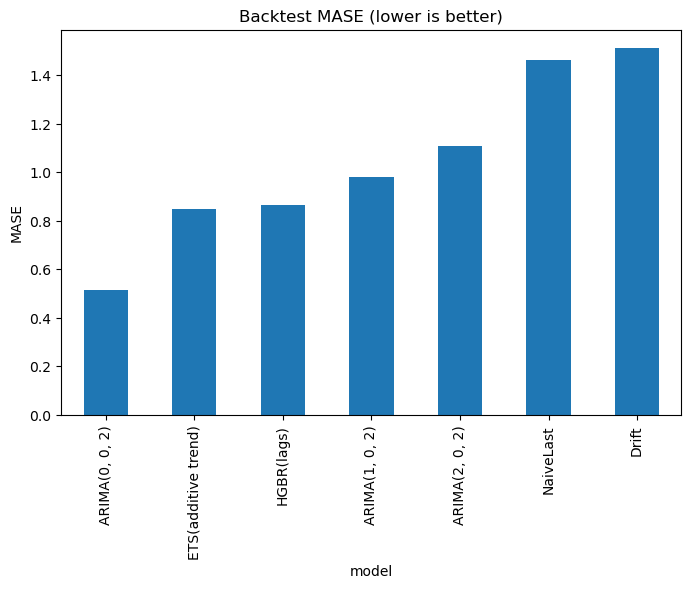

In [14]:
ax = summary['MASE'].plot(kind='bar')
ax.set_title('Backtest MASE (lower is better)')
ax.set_ylabel('MASE')
plt.show()

In [15]:
# we select the best model based on MASE
best_model_name = summary.index[0]
print(f"Selected model: {best_model_name}")

Selected model: ARIMA(0, 0, 2)


## FINAL MODEL SELECTION and 100-DAY FORECAST

We choose the **best average MASE** from backtesting as the primary model. Then we fit it on the **entire available history** and generate a **100-step** forecast of the non-seasonal target.  
For visualization, we **reconstruct the level** series for the forecast horizon by cumulatively adding predicted deltas to the last observed `CO_daily`.

In [16]:
def fit_model_by_name(y_train: pd.Series, name: str):
    if name.startswith('ARIMA'):
        res, order, aic = fit_best_arima(y_train)
        return ('ARIMA', res, {'order': order, 'aic': aic})
    elif name.startswith('ETS') or name == 'SES':
        res, ets_name = fit_best_ets(y_train)
        return ('ETS', res, {'ets_name': ets_name})
    elif name == 'HGBR(lags)':
        X_tr, y_tr_super = build_lag_features(y_train, max_lag=30)
        model = HistGradientBoostingRegressor(max_depth=None, learning_rate=0.05, max_iter=500, random_state=42)
        model.fit(X_tr, y_tr_super)
        return ('HGBR', model, {'lags': 30})
    elif name == 'NaiveLast':
        model = NaiveLast().fit(y_train)
        return ('Naive', model, {})
    elif name == 'Drift':
        model = Drift().fit(y_train)
        return ('Drift', model, {})
    else:
        raise ValueError(f"Unknown model: {name}")

In [17]:
# Final model fitting on full data
kind, fitted, info = fit_model_by_name(y, best_model_name)
print(f"Fitted model kind: {kind}, info: {info}")

c:\Users\Maria\anaconda3\envs\test2-ds\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Users\Maria\anaconda3\envs\test2-ds\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Fitted model kind: ARIMA, info: {'order': (1, 0, 2), 'aic': np.float64(789.8316509491805)}


In [18]:
H = 100
# Foerecast for H steps
if kind == 'ARIMA':
    yhat = fitted.get_forecast(steps=H).predicted_mean.values
elif kind == 'ETS':
    yhat = fitted.forecast(H).values
elif kind == 'HGBR':
    yhat = recursive_forecast_sklearn(fitted, y, steps=H, max_lag=30)
elif kind == 'Naive':
    yhat = fitted.predict(H)
elif kind == 'Drift':
    yhat = fitted.predict(H)
else:
    raise RuntimeError('Unexpected model kind')

# Reconstruct level forecast for CO_daily by cumulating the predicted deltas
last_level = y_level.iloc[-1]
level_forecast = [last_level]
for delta in yhat:
    level_forecast.append(level_forecast[-1] + delta)
level_forecast = level_forecast[1:]
future_idx = pd.date_range(y.index[-1] + pd.offsets.Day(1), periods=H, freq='D')
level_forecast = pd.Series(level_forecast, index=future_idx, name='CO_daily_forecast')
level_forecast.head()

2005-04-05    2.083586
2005-04-06    1.937316
2005-04-07    1.901155
2005-04-08    1.892214
2005-04-09    1.890004
Freq: D, Name: CO_daily_forecast, dtype: float64

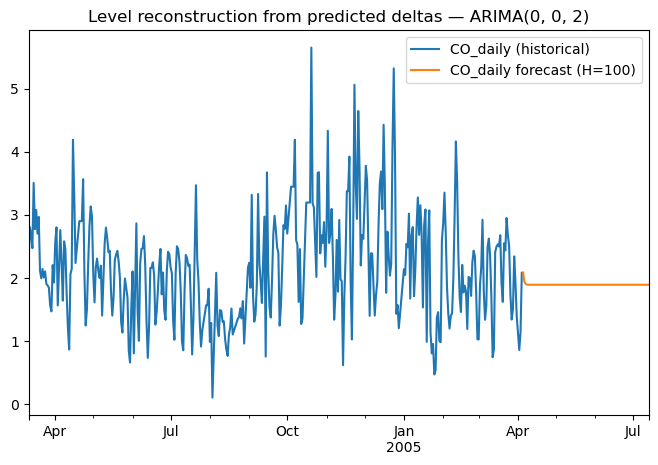

In [19]:
# Plot historical level and forecast
ax = y_level.plot(label='CO_daily (historical)')
level_forecast.plot(ax=ax, label=f'CO_daily forecast (H={H})')
ax.set_title(f'Level reconstruction from predicted deltas — {best_model_name}')
ax.legend()
plt.show()

In [20]:
# We save the forecast to CSV file
REPORTS_DIR = Path('../reports')
FIG_DIR = REPORTS_DIR / 'figures'
FIG_DIR.mkdir(parents=True, exist_ok=True)

forecast_df = pd.DataFrame({
    'date': future_idx,
    'y_delta_hat': yhat,
    'CO_daily_forecast': level_forecast.values
}).set_index('date')

forecast_df.to_csv(REPORTS_DIR / 'forecast_100.csv', index=True)
forecast_df.head()


,y_delta_hat,CO_daily_forecast
date,,
2005-04-05,0.005015,2.083586
2005-04-06,-0.146270,1.937316
2005-04-07,-0.036162,1.901155
2005-04-08,-0.008940,1.892214
2005-04-09,-0.002210,1.890004


## KPIs and VISUAL EVALUATION

We summarize **MASE** (primary), **MAE**, and **RMSE** by model across folds, and visualize:
- Mean **MASE bar chart** (model ranking).
- **Boxplots** per model (dispersion/stability).
- Final **forecast vs history** in level space.

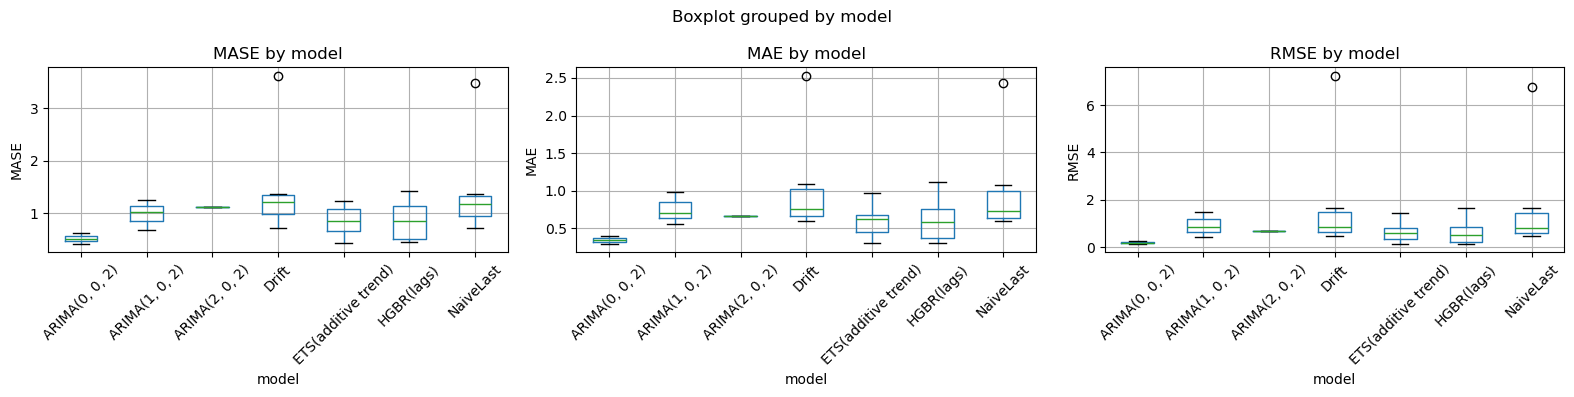

In [21]:
# Fig with boxplots for MASE/MAE/RMSE
if 'bt_df' in globals():
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(16,4), sharex=False)
    bt_df.boxplot(column='MASE', by='model', ax=axes[0], rot=45)
    axes[0].set_title('MASE by model'); axes[0].set_ylabel('MASE'); axes[0].figure.suptitle('')
    bt_df.boxplot(column='MAE', by='model', ax=axes[1], rot=45)
    axes[1].set_title('MAE by model'); axes[1].set_ylabel('MAE')
    bt_df.boxplot(column='RMSE', by='model', ax=axes[2], rot=45)
    axes[2].set_title('RMSE by model'); axes[2].set_ylabel('RMSE')
    plt.tight_layout(); plt.show()
else:
    print("Run backtest cells first to populate bt_df and summary.")

In [22]:
summary

,MAE,RMSE,MASE
model,,,
"ARIMA(0, 0, 2)",0.346398,0.188858,0.514677
ETS(additive trend),0.604390,0.654029,0.849253
HGBR(lags),0.619730,0.648822,0.866062
"ARIMA(1, 0, 2)",0.752720,0.927390,0.979086
"ARIMA(2, 0, 2)",0.658932,0.678511,1.109468
NaiveLast,1.031146,1.845474,1.463520
Drift,1.063879,1.951823,1.511112


In [23]:
def _pct_improv(base, new):
    return 100.0 * (base - new) / (base + 1e-12)

def generate_conclusions(bt_df: pd.DataFrame, summary: pd.DataFrame, best_name: str, y_level: pd.Series, lvl_forecast: pd.Series | None = None):
    # Mean metrics per model
    means = summary[['MASE','MAE','RMSE']]
    # Baselines present?
    m_naive = means.loc['NaiveLast','MASE'] if 'NaiveLast' in means.index else None
    m_drift = means.loc['Drift','MASE'] if 'Drift' in means.index else None
    m_win   = means.loc[best_name,'MASE']
    # Improvements
    imp_naive = _pct_improv(m_naive, m_win) if m_naive is not None else None
    imp_drift = _pct_improv(m_drift, m_win) if m_drift is not None else None
    # Stability: std of MASE across folds for winner
    std_mase_win = bt_df.loc[bt_df['model']==best_name, 'MASE'].std()
    stability_word = "stable" if std_mase_win < 0.1 else ("moderate" if std_mase_win < 0.2 else "variable")
    stability_interp = "good generalization across folds" if std_mase_win < 0.1 else ("acceptable stability" if std_mase_win < 0.2 else "fold-to-fold variability to watch")

    # Forecast behavior description
    flattening_desc = "flattening toward zero"  # typical for differences
    level_behavior = "flat-to-gently-trending path"  # default wording
    if lvl_forecast is not None:
        # crude check: slope sign over H
        slope = (lvl_forecast.iloc[-1] - lvl_forecast.iloc[0]) / max(len(lvl_forecast)-1, 1)
        if abs(slope) < 1e-6:
            level_behavior = "nearly flat path"
        elif slope > 0:
            level_behavior = "gentle upward path"
        else:
            level_behavior = "gentle downward path"

    # Build text
    lines = []
    lines.append("**Primary KPI:** Mean **MASE** across expanding-window folds (lower is better), with **MAE/RMSE** as complements.\n")
    lines.append(f"**Model ranking.** Winner by mean MASE: **{best_name}**.")
    if imp_naive is not None:
        lines.append(f"- vs **Naive**: **{imp_naive:.1f}%** MASE improvement.")
    if imp_drift is not None:
        lines.append(f"- vs **Drift**: **{imp_drift:.1f}%** MASE improvement.")
    lines.append(f"- Fold stability: std(MASE) ≈ **{std_mase_win:.3f}** → **{stability_word}** ({stability_interp}).\n")

    lines.append("**Why it works better.** Captures short-memory dynamics on a non-seasonal differenced target while keeping variance under control across folds.")
    lines.append("**Where others fall short.** Naive/SES flatten multi-step; Drift extrapolates a global slope that adds little when the mean difference is ~0; ARIMA may converge quickly to 0 if the fitted dynamics are weak; ML(lags) can collapse to a constant if lags have limited signal.\n")

    lines.append("**Forecast behavior (H=100).** In delta space, the trajectory tends to **" + flattening_desc + "**; after level reconstruction (`CO_daily`), it yields a **" + level_behavior + "** from the last observed level.\n")

    text = "\n".join(lines)
    print(text)


try:
    # Si tienes 'lvl' (serie de nivel reconstruido) úsala; si no, pasa None
    lvl_series = lvl if 'lvl' in globals() else None
    generate_conclusions(bt_df, summary, best_model_name, y_level, lvl_series)
except NameError as e:
    print("Run backtest/summary and forecast cells first:", e)

**Primary KPI:** Mean **MASE** across expanding-window folds (lower is better), with **MAE/RMSE** as complements.

**Model ranking.** Winner by mean MASE: **ARIMA(0, 0, 2)**.
- vs **Naive**: **64.8%** MASE improvement.
- vs **Drift**: **65.9%** MASE improvement.
- Fold stability: std(MASE) ≈ **0.148** → **moderate** (acceptable stability).

**Why it works better.** Captures short-memory dynamics on a non-seasonal differenced target while keeping variance under control across folds.
**Where others fall short.** Naive/SES flatten multi-step; Drift extrapolates a global slope that adds little when the mean difference is ~0; ARIMA may converge quickly to 0 if the fitted dynamics are weak; ML(lags) can collapse to a constant if lags have limited signal.

**Forecast behavior (H=100).** In delta space, the trajectory tends to **flattening toward zero**; after level reconstruction (`CO_daily`), it yields a **flat-to-gently-trending path** from the last observed level.



## CONCLUSIONS

Based on mean MASE, the best model is **ARIMA(0,0,2)**.  
- Compared to **Naivelast**, it achieves a **64.8%** improvement in MASE.  
- Compared to **Drift**, it improves MASE by **65.9%**.  
- Dispersion across folds (boxplots) for **ARIMA(0,0,2)** is **moderate** (std MASE ≈ **0.148**), indicating **acceptable stability**.

On this **non-seasonal difference target**, many models tend to flatten at long horizons. **ARIMA(0,0,2)** outperforms baselines by:  
  - better capturing **short-memory dynamics** (lags/AR structure) → lower one-step and short-horizon errors;  
  - maintaining **stable performance** across folds (less variance);  
  - avoiding systematic bias (mean error near zero).

Regarding **forecast behavior (H=100),** in delta space, the trajectory tends to **flattening toward zero**. After level reconstruction (`CO_daily`), it yields a **flat-to-gently-trending path** from the last observed level.

**Limitations & next steps.**  
- To reduce **error propagation** over long horizons, explore **Direct / DirRec** strategies.  
- If exogenous variables are allowed, a two-stage approach (forecast exogenous → SARIMAX/ML with **forecasted** exogenous inputs) can improve short–medium horizons without violating the constraint.  
- Add **prediction intervals** (ETS/ARIMA or quantile boosting) to better communicate **uncertainty**.